<a href="https://colab.research.google.com/github/SoniHarsh1/Dynamic-Allocation-Strategies-for-Multi-Agent-Target-Defense-Differential-Games/blob/main/Copy_of_1v4v3_using_PuLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 0]]
time - 0
Target Captured by Attacker 2


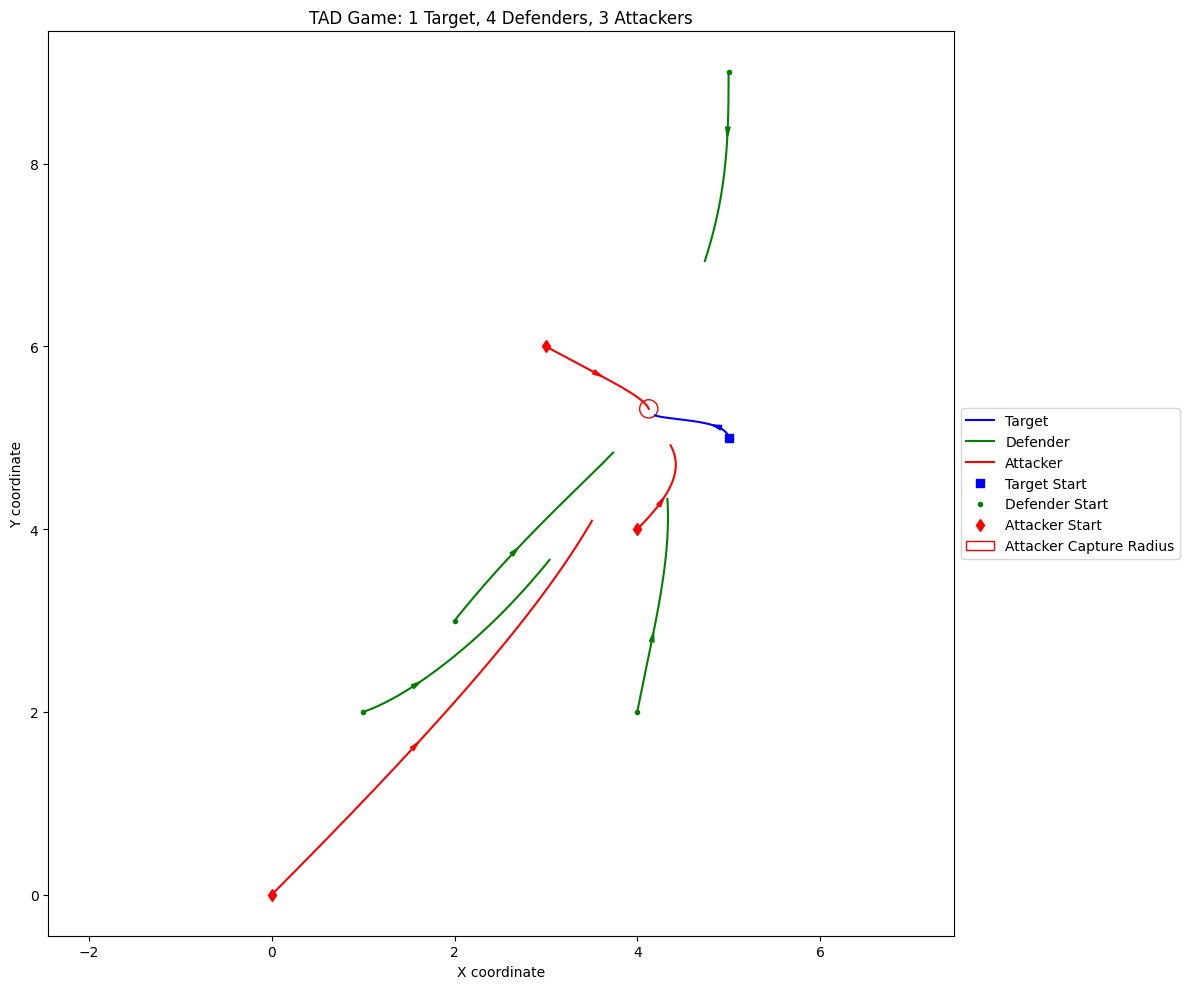

Game Over: Target captured by Attacker 2
Game duration: 0.11 time units


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
!pip install pulp
from pulp import *

# Initial location of the players (1 target, 4 defenders, 3 attackers)
# X_0 = np.array([9, 10, 0, 10, 10, 10, 5, 5, 0, 0, 1, 0, 0, 1, 5, 0])
# X_0 = np.array([5, 5, 1, 2, 2, 3, 4, 2, 5, 9, 0, 0, 3, 6, 6, 7])
X_0 = np.array([5, 5, 1, 2, 2, 3, 4, 2, 5, 9, 0, 0, 3, 6, 4, 4])

# Initialization parameters
O_16 = np.zeros((16, 16))
O = np.zeros((2, 2))
I = np.eye(16)

B_t = np.vstack((np.eye(2), np.zeros((14, 2))))
B_d1 = np.vstack((np.zeros((2, 2)), np.eye(2), np.zeros((12, 2))))
B_d2 = np.vstack((np.zeros((4, 2)), np.eye(2), np.zeros((10, 2))))
B_d3 = np.vstack((np.zeros((6, 2)), np.eye(2), np.zeros((8, 2))))
B_d4 = np.vstack((np.zeros((8, 2)), np.eye(2), np.zeros((6, 2))))
B_a1 = np.vstack((np.zeros((10, 2)), np.eye(2), np.zeros((4, 2))))
B_a2 = np.vstack((np.zeros((12, 2)), np.eye(2), np.zeros((2, 2))))
B_a3 = np.vstack((np.zeros((14, 2)), np.eye(2)))

rt, rd1, rd2, rd3, rd4, ra1, ra2, ra3 = 30, 40, 40, 40, 40, 20, 20, 20
R_t = rt * np.eye(2)
R_d1 = rd1 * np.eye(2)
R_d2 = rd2 * np.eye(2)
R_d3 = rd3 * np.eye(2)
R_d4 = rd4 * np.eye(2)
R_a1 = ra1 * np.eye(2)
R_a2 = ra2 * np.eye(2)
R_a3 = ra3 * np.eye(2)

Q_a1d1T = Q_a2d2T = Q_a3d3T = Q_a1d2T = Q_a1d3T = Q_a2d1T = Q_a2d3T = Q_a3d1T = Q_a3d2T = Q_a1tT = Q_a2tT = Q_a3tT = Q_d1tT = Q_d2tT = Q_d3tT = Q_d4tT = np.eye(2)

S_t = B_t @ inv(R_t) @ B_t.T
S_d1 = B_d1 @ inv(R_d1) @ B_d1.T
S_d2 = B_d2 @ inv(R_d2) @ B_d2.T
S_d3 = B_d3 @ inv(R_d3) @ B_d3.T
S_d4 = B_d4 @ inv(R_d4) @ B_d4.T
S_a1 = B_a1 @ inv(R_a1) @ B_a1.T
S_a2 = B_a2 @ inv(R_a2) @ B_a2.T
S_a3 = B_a3 @ inv(R_a3) @ B_a3.T

# Initialize variables to store capture information
captured_by_attacker = False
all_attackers_captured = False
capturing_agent_index = None
captured_attackers = [False, False, False]

def euclidean_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

# Get the assignment using PuLP
def get_assignment(defenders, attackers, captured_attackers):
    num_defenders = len(defenders)
    num_attackers = len(attackers)

    # Create the LP problem
    prob = LpProblem("Defender-Attacker_Assignment", LpMinimize)

    # Create decision variables only for non-captured attackers
    choices = LpVariable.dicts("Choice",
                               ((i, j) for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]),
                               cat='Binary')

    # Objective function
    prob += lpSum([euclidean_distance(defenders[i], attackers[j]) * choices[(i, j)]
                   for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]])

    # Constraints
    for j in range(num_attackers):
        if not captured_attackers[j]:
            prob += lpSum([choices[(i, j)] for i in range(num_defenders)]) == 1

    for i in range(num_defenders):
        prob += lpSum([choices[(i, j)] for j in range(num_attackers) if not captured_attackers[j]]) <= 1

    # Solve the problem
    prob.solve()

    # Create the assignment matrix (maintaining original dimensions)
    assignment_matrix = np.zeros((num_defenders, num_attackers), dtype=int)
    for i in range(num_defenders):
        for j in range(num_attackers):
            if not captured_attackers[j] and (i, j) in choices:
                if choices[(i, j)].value() == 1:
                    assignment_matrix[i][j] = 1

    return assignment_matrix

# Step size and T selection
T = 0.02
tk = 0
step1 = 100
deltaT = T / step1
j = 0
sigmaa = 0.1
sigmad = 0.1
sigmat = 0
tflag = 0
time = [tk]
count = 0
X_t = []

check = np.zeros((4, 3), dtype=int)

while tflag == 0:
    defenders = [X_0[2:4], X_0[4:6], X_0[6:8], X_0[8:10]]
    attackers = [X_0[10:12], X_0[12:14], X_0[14:16]]

    # Get the assignment matrix
    Asgn = get_assignment(defenders, attackers, captured_attackers)

    if(check != Asgn).any():
        print(Asgn)
        check = Asgn
        print("time -", time[-1])

    Q_t = np.block([
        [Q_d1tT+Q_d2tT+Q_d3tT+Q_d4tT-Q_a1tT-Q_a2tT-Q_a3tT, -Q_d1tT, -Q_d2tT, -Q_d3tT, -Q_d4tT, Q_a1tT, Q_a2tT, Q_a3tT],
        [-Q_d1tT, Q_d1tT, O, O, O, O, O, O],
        [-Q_d2tT, O, Q_d2tT, O, O, O, O, O],
        [-Q_d3tT, O, O, Q_d3tT, O, O, O, O],
        [-Q_d4tT, O, O, O, Q_d4tT, O, O, O],
        [Q_a1tT, O, O, O, O, -Q_a1tT, O, O],
        [Q_a2tT, O, O, O, O, O, -Q_a2tT, O],
        [Q_a3tT, O, O, O, O, O, O, -Q_a3tT]
    ])

    Q_d1 = np.block([
        [Q_d1tT, -Q_d1tT, O, O, O, O, O, O],
        [-Q_d1tT, Q_d1tT+Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d1T+Asgn[0][2]*Q_a3d1T, O, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d1T, -Asgn[0][2]*Q_a3d1T],
        [O, O, Asgn[1][0]*Q_a1d2T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d2T, O, O, -Asgn[1][0]*Q_a1d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d2T],
        [O, O, O, Asgn[2][0]*Q_a1d3T+Asgn[2][1]*Q_a2d3T+Asgn[2][2]*Q_a3d3T, O, -Asgn[2][0]*Q_a1d3T, -Asgn[2][1]*Q_a2d3T, -Asgn[2][2]*Q_a3d3T],
        [O, O, O, O, Asgn[3][0]*Q_a1d3T+Asgn[3][1]*Q_a2d3T+Asgn[3][2]*Q_a3d3T, -Asgn[3][0]*Q_a1d3T, -Asgn[3][1]*Q_a2d3T, -Asgn[3][2]*Q_a3d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d2T, -Asgn[2][0]*Q_a1d3T, -Asgn[3][0]*Q_a1d3T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d2T+Asgn[2][0]*Q_a1d3T+Asgn[3][0]*Q_a1d3T, O, O],
        [O, -Asgn[0][1]*Q_a2d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d3T, -Asgn[3][1]*Q_a2d3T, O, Asgn[0][1]*Q_a2d1T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d3T+Asgn[3][1]*Q_a2d3T, O],
        [O, -Asgn[0][2]*Q_a3d1T, -Asgn[1][2]*Q_a3d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[3][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d1T+Asgn[1][2]*Q_a3d2T+Asgn[2][2]*Q_a3d3T+Asgn[3][2]*Q_a3d3T]
    ])

    Q_d2 = np.block([
        [Q_d2tT, O, -Q_d2tT, O, O, O, O, O],
        [O, Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d1T+Asgn[0][2]*Q_a3d1T, O, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d1T, -Asgn[0][2]*Q_a3d1T],
        [-Q_d2tT, O, Q_d2tT+Asgn[1][0]*Q_a1d2T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d2T, O, O, -Asgn[1][0]*Q_a1d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d2T],
        [O, O, O, Asgn[2][0]*Q_a1d3T+Asgn[2][1]*Q_a2d3T+Asgn[2][2]*Q_a3d3T, O, -Asgn[2][0]*Q_a1d3T, -Asgn[2][1]*Q_a2d3T, -Asgn[2][2]*Q_a3d3T],
        [O, O, O, O, Asgn[3][0]*Q_a1d3T+Asgn[3][1]*Q_a2d3T+Asgn[3][2]*Q_a3d3T, -Asgn[3][0]*Q_a1d3T, -Asgn[3][1]*Q_a2d3T, -Asgn[3][2]*Q_a3d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d2T, -Asgn[2][0]*Q_a1d3T, -Asgn[3][0]*Q_a1d3T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d2T+Asgn[2][0]*Q_a1d3T+Asgn[3][0]*Q_a1d3T, O, O],
        [O, -Asgn[0][1]*Q_a2d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d3T, -Asgn[3][1]*Q_a2d3T, O, Asgn[0][1]*Q_a2d1T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d3T+Asgn[3][1]*Q_a2d3T, O],
        [O, -Asgn[0][2]*Q_a3d1T, -Asgn[1][2]*Q_a3d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[3][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d1T+Asgn[1][2]*Q_a3d2T+Asgn[2][2]*Q_a3d3T+Asgn[3][2]*Q_a3d3T]
    ])

    Q_d3 = np.block([
        [Q_d3tT, O, O, -Q_d3tT, O, O, O, O],
        [O, Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d1T+Asgn[0][2]*Q_a3d1T, O, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d1T, -Asgn[0][2]*Q_a3d1T],
        [O, O, Asgn[1][0]*Q_a1d2T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d2T, O, O, -Asgn[1][0]*Q_a1d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d2T],
        [-Q_d3tT, O, O, Q_d3tT+Asgn[2][0]*Q_a1d3T+Asgn[2][1]*Q_a2d3T+Asgn[2][2]*Q_a3d3T, O, -Asgn[2][0]*Q_a1d3T, -Asgn[2][1]*Q_a2d3T, -Asgn[2][2]*Q_a3d3T],
        [O, O, O, O, Asgn[3][0]*Q_a1d3T+Asgn[3][1]*Q_a2d3T+Asgn[3][2]*Q_a3d3T, -Asgn[3][0]*Q_a1d3T, -Asgn[3][1]*Q_a2d3T, -Asgn[3][2]*Q_a3d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d2T, -Asgn[2][0]*Q_a1d3T, -Asgn[3][0]*Q_a1d3T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d2T+Asgn[2][0]*Q_a1d3T+Asgn[3][0]*Q_a1d3T, O, O],
        [O, -Asgn[0][1]*Q_a2d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d3T, -Asgn[3][1]*Q_a2d3T, O, Asgn[0][1]*Q_a2d1T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d3T+Asgn[3][1]*Q_a2d3T, O],
        [O, -Asgn[0][2]*Q_a3d1T, -Asgn[1][2]*Q_a3d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[3][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d1T+Asgn[1][2]*Q_a3d2T+Asgn[2][2]*Q_a3d3T+Asgn[3][2]*Q_a3d3T]
    ])

    Q_d4 = np.block([
        [Q_d4tT, O, O, O, -Q_d4tT, O, O, O],
        [O, Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d1T+Asgn[0][2]*Q_a3d1T, O, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d1T, -Asgn[0][2]*Q_a3d1T],
        [O, O, Asgn[1][0]*Q_a1d2T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d2T, O, O, -Asgn[1][0]*Q_a1d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d2T],
        [O, O, O, Asgn[2][0]*Q_a1d3T+Asgn[2][1]*Q_a2d3T+Asgn[2][2]*Q_a3d3T, O, -Asgn[2][0]*Q_a1d3T, -Asgn[2][1]*Q_a2d3T, -Asgn[2][2]*Q_a3d3T],
        [-Q_d4tT, O, O, O, Q_d4tT+Asgn[3][0]*Q_a1d3T+Asgn[3][1]*Q_a2d3T+Asgn[3][2]*Q_a3d3T, -Asgn[3][0]*Q_a1d3T, -Asgn[3][1]*Q_a2d3T, -Asgn[3][2]*Q_a3d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d2T, -Asgn[2][0]*Q_a1d3T, -Asgn[3][0]*Q_a1d3T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d2T+Asgn[2][0]*Q_a1d3T+Asgn[3][0]*Q_a1d3T, O, O],
        [O, -Asgn[0][1]*Q_a2d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d3T, -Asgn[3][1]*Q_a2d3T, O, Asgn[0][1]*Q_a2d1T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d3T+Asgn[3][1]*Q_a2d3T, O],
        [O, -Asgn[0][2]*Q_a3d1T, -Asgn[1][2]*Q_a3d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[3][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d1T+Asgn[1][2]*Q_a3d2T+Asgn[2][2]*Q_a3d3T+Asgn[3][2]*Q_a3d3T]
    ])

    Q_a1 = np.block([
        [Q_a1tT, O, O, O, O, -Q_a1tT, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a1tT, O, O, O, O, Q_a1tT, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O]
    ])

    Q_a2 = np.block([
        [Q_a2tT, O, O, O, O, O, -Q_a2tT, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a2tT, O, O, O, O, O, Q_a2tT, O],
        [O, O, O, O, O, O, O, O]
    ])

    Q_a3 = np.block([
        [Q_a3tT, O, O, O, O, O, O, -Q_a3tT],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a3tT, O, O, O, O, O, O, Q_a3tT]
    ])

    M = np.block([
        [O_16, -S_t, -S_d1, -S_d2, -S_d3, -S_d4, -S_a1, -S_a2, -S_a3],
        [-Q_a1, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_a2, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_a3, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d1, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d2, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d3, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d4, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_t, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16]
    ])

    Q = np.vstack((I, Q_t, Q_d1, Q_d2, Q_d3, Q_d4, Q_a1, Q_a2, Q_a3))
    H_T = np.hstack((I, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16)) @ expm(-M * (tk + T)) @ Q
    Y = expm(-M * T) @ Q @ inv(H_T) @ X_0

    # Update positions only for active agents
    new_X_0 = X_0.copy().astype(float)
    new_X_0[:10] = Y[:10]  # Update target and defenders
    for i in range(3):
        if not captured_attackers[i]:
            new_X_0[10+2*i:12+2*i] = Y[10+2*i:12+2*i]  # Update active attackers
    X_0 = new_X_0

    X_t.append(X_0)

    # Check for captures
    for i in range(3):
        if np.linalg.norm(Y[:2] - Y[10+2*i:12+2*i]) <= sigmaa and not captured_attackers[i]:
            print(f'Target Captured by Attacker {i+1}')
            captured_by_attacker = True
            capturing_agent_index = i
            tflag = 1
            break

    if not captured_by_attacker:
        for i in range(4):
            for j in range(3):
                if np.linalg.norm(Y[2+2*i:4+2*i] - Y[10+2*j:12+2*j]) <= sigmad and not captured_attackers[j]:
                    print(f'Attacker {j+1} Captured by Defender {i+1}')
                    captured_attackers[j] = True
                    capturing_agent_index = i
                    break
            if all(captured_attackers):
                all_attackers_captured = True
                tflag = 1
                break
    j += 1
    tk += deltaT
    count += 1
    time.append(tk)

X_t = np.array(X_t).T

# Plotting
plt.figure(figsize=(12, 10))
plt.plot(X_t[0], X_t[1], color='b', linewidth=1.5, label='Target')
plt.plot(X_t[2], X_t[3], color='g', linewidth=1.5, label='Defender')
plt.plot(X_t[4], X_t[5], color='g', linewidth=1.5)
plt.plot(X_t[6], X_t[7], color='g', linewidth=1.5)
plt.plot(X_t[8], X_t[9], color='g', linewidth=1.5)
plt.plot(X_t[10], X_t[11], color='r', linewidth=1.5, label='Attacker')
plt.plot(X_t[12], X_t[13], color='r', linewidth=1.5)
plt.plot(X_t[14], X_t[15], color='r', linewidth=1.5)

# Add markers to the initial positions
plt.plot(X_t[0, 0], X_t[1, 0], 's', markersize=6, color='b', label='Target Start')
plt.plot(X_t[2, 0], X_t[3, 0], '.', markersize=6, color='g', label='Defender Start')
plt.plot(X_t[4, 0], X_t[5, 0], '.', markersize=6, color='g')
plt.plot(X_t[6, 0], X_t[7, 0], '.', markersize=6, color='g')
plt.plot(X_t[8, 0], X_t[9, 0], '.', markersize=6, color='g')
plt.plot(X_t[10, 0], X_t[11, 0], 'd', markersize=6, color='r', label='Attacker Start')
plt.plot(X_t[12, 0], X_t[13, 0], 'd', markersize=6, color='r')
plt.plot(X_t[14, 0], X_t[15, 0], 'd', markersize=6, color='r')

# Add arrows to show direction of movement
mid_point = len(X_t[0]) // 2
arrow_length = 0.1
arrow_width = 0.05
arrow_color = 'black'

# Function to add arrow
def add_arrow(x, y, dx, dy, color):
    plt.arrow(x, y, dx, dy, head_width=arrow_width, head_length=arrow_length,
              fc=color, ec=color, length_includes_head=True)

# Add arrows for all entities
for i in range(0, 16, 2):
    add_arrow(X_t[i, mid_point], X_t[i+1, mid_point],
              X_t[i, mid_point+1] - X_t[i, mid_point],
              X_t[i+1, mid_point+1] - X_t[i+1, mid_point],
              'blue' if i == 0 else ('green' if i < 10 else 'red'))

# Add capture zones
if captured_by_attacker:
    circle = plt.Circle((X_t[10+2*capturing_agent_index, -1], X_t[11+2*capturing_agent_index, -1]),
                        sigmaa, fill=False, edgecolor='r', label='Attacker Capture Radius')
    plt.gca().add_artist(circle)
if any(captured_attackers):
    capture_radius_added = False
    for i in range(4):  # For each defender
        for j in range(3):  # For each attacker
            if captured_attackers[j]:
                # Find the time step where the capture occurred
                capture_step = next((step for step in range(len(X_t[0]))
                                     if np.linalg.norm(X_t[2+2*i:4+2*i, step] - X_t[10+2*j:12+2*j, step]) <= sigmad), None)
                if capture_step is not None:
                    circle = plt.Circle((X_t[2+2*i, capture_step], X_t[3+2*i, capture_step]),
                                        sigmad, fill=False, edgecolor='g',
                                        label='Defender Capture Radius' if not capture_radius_added else "")
                    plt.gca().add_artist(circle)
                    capture_radius_added = True

plt.axis('equal')
plt.legend(fontsize="10", loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('TAD Game: 1 Target, 4 Defenders, 3 Attackers')
plt.tight_layout()
plt.show()

# Print game result
if captured_by_attacker:
    print(f"Game Over: Target captured by Attacker {capturing_agent_index + 1}")
elif all_attackers_captured:
    print("Game Over: All Attackers captured by Defenders")
else:
    print("Game ended without capture")

print(f"Game duration: {time[-1]:.2f} time units")